# Briefing


Here we'll work with the field area occupied by players of each team.
It's one of many metrics that can be extract from player positional data in NFL datasets.

A play is composed for many frames that capture a snapshot os player positions in the field,
in the same way a movie conveys movent by showing different pictures.
For each frame we have the position of all participating players, so we can draw a polygon for
each team that contains their respective players, as shown in Figure 1.


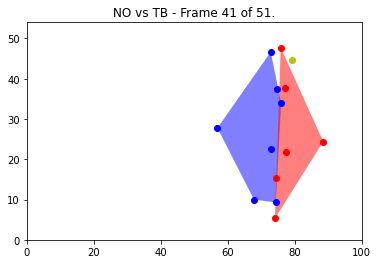



The topology from such areas (here called 'territories') may contain for patterns that more likely to show up in a sucessful defensive play. Wether there are such detectable patterns ir currently unknown.

Here we present this concept, and will analyze briefly those patterns and
some of their attributes, such as:

* Distance from centroid of the territory to the main player
* Mean size of the territory across all frames of the play
* Size of the territory in the first frame.
* ...

The analysis consists of the independent correlation of each play's metrics with the plays EPA,
which measures the points gained (its an estimation) at the end of that specific play;

For most of the features we'll consider the territory of the offensive team, the T of the defensive team, and the metric for the defensive team minus the metric for the offensive team (a delta).

We'll go through an analysis for every defensive play in the 2018 season, 
checking how certain team topology features correlate to that play EPA.



# Results

No significant correlation was found between `EPA` and multiple simple metrics on each teams territory.

The methods employed here are rather basic, and ignores most of the data provided in the datasets such as
the play type, wether the pass was successful or not, etc. A bigger analytics team could take advantage of 
those and build a complex system to account for multiple input types to work along territory metrics.

The use of advanced techniques such as NN, and maybe LSTM to process the temporal aspect of a frame stack 
that compose a Play may be employed to search further for features in the territory correlated with the play result.

An ideal evolution of the concept would be the possibility to predict outcomes using only the initial frames of the play,
meaning the machine is able to identify certain defensive setups that maximizes success rates, and then a coach could grab that information to improve the team's tactics.

Actual result values can be found in the last cell of this notebook.

# Appendix: Code


In [ ]:

# kaggle/python Docker image: https://github.com/kaggle/docker-python

import datetime
from typing import List
import numpy as np
import pandas as pd
import itertools
import scipy.spatial as spat

from shapely.geometry import MultiPoint, Polygon

import plotly.figure_factory as ff


import statistics as stats
import matplotlib.pyplot as plt
from IPython.display import Image


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
DATA_ROOT = "/kaggle/input/nfl-big-data-bowl-2021"

OUTPUT_PATH = "/kaggle/output/nfl-big-data-bowl-2021"

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
#Image(filename="/kaggle/output/nfl-big-data-bowl-2021/sample_frame.png")

In [ ]:
def dataframe_search(df, f):
    for index, row in df.iterrows():
        # Define your criteria here
        if f(row):
            return row

class Game():
    GameTime: datetime.datetime
    Teams = List[str]
    
    def __init__(self, game_id, week_data, game_data):
        #self.Data = week_data[week_data["gameId"] == game_id]
        
        gd = dataframe_search(game_data, lambda gdata: gdata["gameId"] == game_id)
        
        self.GameTime = datetime.datetime.strptime(gd["gameTimeEastern"], "%H:%M:%S")
        
        self.Teams = [gd[h] for h in ["homeTeamAbbr", "visitorTeamAbbr"]]

        
    def get_player_Nplays(self, player_name):
        player_move = self.Data[self.Data["displayName"] == player_name]
        
        return player_move.shape[0]
        
    def get_game_hour(self):
        return self.GameTime.hour
    

In [ ]:
class Topology():
    """
    Information 
    
    """
    Area: float
        
    def __init__(self, x):
        self.InitialArea = None
        
        

In [ ]:
def check_nplayers(df, c=11):
    N = df.shape[0]
    if not (N == c):
        print(f"BAD PLAYER NUMBER: {N}   .. expected {c}.")
        
class Frame():
    PlayId: str
        
    #FIXME: Duplicated
    Frames: pd.DataFrame
    Positions: pd.DataFrame
    Teams: List[str]
    AttackerTeam: str
        
    def __init__(self, frames, play):
        self.Positions = frames
        self.Frames = frames
        self.Teams = play.Teams
        self.AttackerTeam = play.AttackerTeam
        self.DefenderTeam = play.DefenderTeam
        
        self.Play = play
        
    def plot(self, i, fpath=None):
        for p, player in enumerate(self.Positions.iloc()):
            # Red players are on the the attacker team;
            if player.team == "football":
                plt.plot([player.x], [player.y], 'yo')
            
        TEAMS = [('b', self.DefenderTeam), ('r', self.AttackerTeam)]
        for color, team in TEAMS:
            team_points = self.Positions[self.Positions["team"] == team]
        

                
            points = np.array(list(zip(team_points.x, team_points.y)))
            hull = spat.ConvexHull(points)
            polyg = MultiPoint(points).convex_hull

            x, y = polyg.exterior.xy
            #print(hull.simplices)
            plt.plot(team_points.x, team_points.y, color + "o")
            
            #for simplex in hull.simplices:
            #    plt.plot(points[simplex, 0], points[simplex,1], color + '-')
            
            #plt.plot(x, y, color + '-')
            plt.fill(x, y, alpha=0.5, fc=color, ec='none')
            
        #fill_between(x, y1, y2)
        plt.xlim(left=0, right=100)
        plt.ylim(bottom=0, top=54)
        plt.title(f"{self.Play.identifier()} - Frame {i} of {len(self.Play.Frames)}.")
        
        if fpath:
            plt.savefig(fpath)
        else:
            plt.show()

In [ ]:
class Play():
    Result: bool
    Moves: pd.DataFrame
    Frames: List[Frame]
    Teams: List[str]
    AttackerTeam: str
    DefenderTeam: str
    PlayResult: int
        
    EPA: float
    def __init__(self, play_id, coord_data, play_data, game):
        self.Moves = coord_data
        self.Teams = game.Teams
        
        self.PlayData = play_data[play_data["playId"] == play_id].iloc[0]
        
        self.AttackerTeam = "home" if self.PlayData["possessionTeam"] == self.Teams[0] else "away"
        self.DefenderTeam = "home" if self.AttackerTeam == "away" else "away"
        
        self.EPA = self.PlayData["epa"].astype(float)
        
        self.Result = self.PlayData["passResult"]
        
        self.Frames = self.separate_frames()
        
        
        self.PlayResult = self.PlayData["playResult"]
        
    def plot(self, interval=5):
        for f, frame in enumerate(self.Frames):
            if f % interval: continue
            frame.plot(f + 1)
        
    def separate_frames(self) -> List[Frame]:
        Frames = []
        for time_stamp, pd in self.Moves.groupby(self.Moves["time"]):
            Frames.append(Frame(pd, self))

        return Frames
    
    def identifier(self):
        return " vs ".join(self.Teams)
            

In [ ]:
def load_week(week_n)            :
    data_path = os.path.join(DATA_ROOT, f"week{week_n}.csv")
    return pd.read_csv(data_path)

In [ ]:
def load_plays(coord_data, play_data):
    
    Plays = []
    
    coord_groups = coord_data.groupby(coord_data["playId"])
    
    print(f"Loading {len(coord_groups)} plays...")
    for i, (playId, coord_play_data) in enumerate(coord_groups):
        # print(f"play {i + 1}")
        try:
            gameId = coord_play_data.iloc[0]["gameId"]
        except:
            print(coord_play_data)
            print("fail")
            continue
            
        game = Game(gameId, coord_play_data, game_data)
        P = Play(playId, coord_play_data, play_data, game)
        Plays.append(P)
        
    return Plays
        


In [ ]:
def to_points(x, y):
    return np.array(list(zip(x, y)))

def calculate_area(X, Y):
    points = to_points(X, Y)
    hull = spat.ConvexHull(points)
    
    return hull.volume

def get_hull(points):
    return spat.Convex

def calculate_centroid(hull):
    cx = np.mean(hull.points[hull.vertices,0])
    cy = np.mean(hull.points[hull.vertices,1])
    
    return(np.array((cx, cy)))

def calculate_ecc(points):
    small_latwise = np.min(points[points[:, 0] == np.min(points[:, 0])], 0)
    small_lonwise = np.min(points[points[:, 1] == np.min(points[:, 1])], 0)
    big_latwise = np.max(points[points[:, 0] == np.max(points[:, 0])], 0)
    big_lonwise = np.max(points[points[:, 1] == np.max(points[:, 1])], 0)
    distance_lat = spat.distance.euclidean(big_latwise, small_latwise)
    distance_lon = spat.distance.euclidean(big_lonwise, small_lonwise)
    if distance_lat >= distance_lon:
        major_axis_length = distance_lat
        minor_axis_length = distance_lon
    else:
        major_axis_length = distance_lon
        minor_axis_length = distance_lat
    a = major_axis_length/2
    b = minor_axis_length/2
    ecc = np.sqrt(np.square(a)-np.square(b))/a
    return ecc


In [ ]:
def stereo_mean(D):
    return np.mean(D, axis=1)


def only_valid_corr(A, B):
    w = zip(A, B)
    a = []
    b = []
    for Ax, Bx in w:
        if None in [Ax, Bx]:
            continue
        a.append(Ax)
        b.append(Bx)
    
    
    return np.corrcoef(a, b)[0][1]
    
def evaluate_team_area(play: Play):
    FrameAreas = []
    FrameEcc = []
    CBDists = []
    SPDs = []
    Intersects = []
    for frame in play.Frames:

        F = frame.Positions
        #print(F)
        
        AttackerPlayers = F[F["team"] == play.AttackerTeam]
        DefensePlayers = F[F["team"] == play.DefenderTeam]
 
        if AttackerPlayers.empty or DefensePlayers.empty: continue
            
        player_types = [AttackerPlayers, DefensePlayers]
        
        Coordinates = [to_points(V.x, V.y) for V in player_types]
        
        try:
            Hulls = [spat.ConvexHull(pts) for pts in Coordinates]
        except spat.qhull.QhullError:
            print("Hull Error")
            continue
            

            
        
        Centroids = [calculate_centroid(hull) for hull in Hulls]
        
        cbs = [dataframe_search(pt, lambda df: df.position in ["QB", "ML"]) for pt in player_types]
        
        # PLAYER MEAN SPEED
        spds = [players.s.mean() for players in player_types]
        SPDs.append(spds)

        # AREA INTERSECTION
        p1, p2 = [Polygon(ps) for ps in Coordinates]
        Intersects.append(p1.intersects(p2))
        
        try:
            cbpos = [np.array((cb.x, cb.y)) for cb in cbs if cb is not None]
        except:
            raise
            print(cbs)
            continue
        """
        try:
            cbdist = [spat.distance.cdist(cbpos[i].reshape(-1,2), Centroids[i].reshape(-1, 2)).sum() for i in range(1)]
        except:
            cbdist = [0, 0]
        """    
        #CBDists.append(cbdist)
        Areas = [calculate_area(V.x, V.y) for V in player_types]
        FrameAreas.append(Areas)
        
        Ecc = [calculate_ecc(to_points(V.x, V.y)) for V in player_types]
        FrameEcc.append(Ecc)
        
    L = len(FrameAreas)
    if not L: return None
    return { "intersection": Intersects,
        
    "comparison": {
        "initial_area": FrameAreas[0],
        "all_frames_mean_area": stereo_mean(FrameAreas),
        "final_area": FrameAreas[-1],
        "expansion": [FrameAreas[L//2][i] - FrameAreas[0][i] for i in range(2)],
        "def_ecc": stereo_mean(FrameEcc),
        #"distance_CB": stereo_mean(CBDists),
        "player_speeds": stereo_mean(SPDs),
    }
    }

FrameMetrics = [
    # Average player distance
    # STD Player Distance
    # 
]
  
def interprete_results(results):
    w = results[0]
    
    res = []
    for name in w["comparison"].keys():
        res.append((name + " attackers", [k["comparison"][name][0] for k in results]))
        res.append((name + " defenders", [k["comparison"][name][1] for k in results]))
        res.append((name + " delta", [k["comparison"][name][1] - k["comparison"][name][0] for k in results]))
        
    def interprete_intersection(intersec_vector):
        L = len(intersec_vector)
        try:
            a = intersec_vector.index(True)
        except:
            return None
            
        return a / L
    
    EarliestIntersections = [interprete_intersection(result["intersection"]) for result in results]
    
    res.append(("Earliest Intersection", EarliestIntersections))
    
    return res


def analyze_week(n, week_plays):
    print(f"Analyzing Week {n}")
    Results = []
    EPAs = []
    
    for p, play in enumerate(week_plays):
        if p and not p % 300:
            print("%.2f%%" % (p / len(week_plays) * 100))
            #print(f"Play {p + 1} of {len(week_plays)}")
            #print(play.identifier())
        play_result = evaluate_team_area(play)
        if play_result is not None:
            Results.append(play_result)
            EPAs.append(play.EPA)
        

    print("NB Plays: %i" % len(Results))
    
    correlations = pd.DataFrame(columns=["Feature", "EPA"])
    for result_name, values in interprete_results(Results):
        try:
            corr = np.corrcoef(values, EPAs)[0][1]
        except TypeError:
            corr = only_valid_corr(values, EPAs)
   
        correlations.loc[correlations.shape[0]] = (result_name, corr)
        


    return correlations

In [ ]:
    
game_data = pd.read_csv(os.path.join(DATA_ROOT, "games.csv"))
player_data = pd.read_csv(os.path.join(DATA_ROOT, "players.csv"))
play_data = pd.read_csv(os.path.join(DATA_ROOT, "plays.csv"))
    
players = player_data["displayName"]

In [ ]:


#PLAYS[0].Frames[0].plot(0, os.path.join(OUTPUT_PATH, "sample_frame.png"))

#PLAYS[0].plot()

In [ ]:
#WEEKS_SEP = [read_week(i, game_data) for i in range(1, 6)]
#WEEKS = list(itertools.chain.from_iterable(WEEKS_SEP))

for w in range(1, 10): # can be range(1, 18) but that would take a long time to run.
    print(f"Processing week {w}...")
    week_df = load_week(w)
    week_plays = load_plays(week_df, play_data)
    week_results = analyze_week(w, week_plays)
    
    #print(week_results.to_string(index=False))
    dffig = ff.create_table(week_results)
    dffig.show()